In [15]:
## Download relevant data+models for testing MDTerp

import urllib.request
import zipfile
import os

url = "https://figshare.com/ndownloader/articles/30351334/versions/7"
filename = "MDTerp_files.zip"

urllib.request.urlretrieve(url, filename)
print(f"Downloaded {filename}")

zip_path = "MDTerp_files.zip"
extract_dir = "./"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")

Downloaded MDTerp_files.zip
Files extracted to: ./


In [16]:
# Let's create a synthetic dataset with 10 numeric (non-periodic) features, 5 angular (periodic) and 2 sine/cosine features. Typically this will be the training data for your black-box

In [17]:
import numpy as np

synthetic_dataset_size = 20000

synthetic_numeric = np.random.uniform(-5, 10, (synthetic_dataset_size, 10)) # For numeric
synthetic_angle = np.random.uniform(-np.pi, np.pi, (synthetic_dataset_size, 5)) # For angle
synthetic_sin_cos = np.random.uniform(-np.pi, np.pi, (synthetic_dataset_size, 2)) # For sine/cosine

synthetic_data = np.column_stack((synthetic_numeric, synthetic_angle, np.sin(synthetic_sin_cos), np.cos(synthetic_sin_cos)))

print("Synthetic dataset created with size >>>", synthetic_data.shape)

Synthetic dataset created with size >>> (20000, 19)


In [18]:
# MDTerp step 1: Create dictionaries for numeric, angular, sine/cosine features. Key of dictionaries should be any name given by user (used for figures later) for identifying the features. Values must be lists. Each numeric, angular feature will have only one elements in each list. Each sine/cosine feature will have two elements in each list corresponding to sine/cosine indices of a specific angle respectively.
# For this example we will consider numeric features only.

numeric_dict = {}
for i in range(10):
    numeric_dict['numeric_' + str(i)] = [i]

angle_dict = {}
for i in range(5):
    angle_dict['angle_' + str(i)] = [10 + i]

sin_cos_dict = {}
sin_cos_dict['sin_cos_0'] = [15, 17] # Index 15, 17 of synthetic_data represents sin/cosine of a single angle variable
sin_cos_dict['sin_cos_1'] = [16, 18] # Index 16, 18 of synthetic_data represents sin/cosine of a single angle variable

print(numeric_dict)
print(angle_dict)
print(sin_cos_dict)

{'numeric_0': [0], 'numeric_1': [1], 'numeric_2': [2], 'numeric_3': [3], 'numeric_4': [4], 'numeric_5': [5], 'numeric_6': [6], 'numeric_7': [7], 'numeric_8': [8], 'numeric_9': [9]}
{'angle_0': [10], 'angle_1': [11], 'angle_2': [12], 'angle_3': [13], 'angle_4': [14]}
{'sin_cos_0': [15, 17], 'sin_cos_1': [16, 18]}


In [19]:
# MDTerp step 2: Import MDTerp.base and implement MDTerp using base.run(). Two required arguments are the dataset and the location of a Python function that loads a black-box model. Go to https://github.com/shams-mehdi/MDTerp/tree/main/examples to check how this Python file should be like.

import MDTerp.base as base
import os

result_dir = './results/'
os.makedirs(result_dir, exist_ok = True)

model_function_loc =  'MDTerp_files/scripts/MDTerp_script_blackbox.txt'
base.run(synthetic_data, model_function_loc, save_dir = result_dir, numeric_dict = numeric_dict, angle_dict = angle_dict, sin_cos_dict = sin_cos_dict , point_max = 10, prob_threshold = 0.499, num_samples = 10000)

10-17-25 17:20:53 initialization  INFO     ----------------------------------------------------------------------------------------------------
10-17-25 17:20:53 initialization  INFO     Starting MDTerp...
10-17-25 17:20:53 initialization  INFO     ----------------------------------------------------------------------------------------------------
10-17-25 17:20:53 initialization  INFO     MDTerp result location >>> ./results/
10-17-25 17:20:53 initialization  INFO     Defined numeric features >>> 10
10-17-25 17:20:53 initialization  INFO     Defined angle features >>> 5
10-17-25 17:20:53 initialization  INFO     Defined sin_cos features >>> 2
10-17-25 17:20:53 initialization  INFO     Number of samples in blackbox model training data >>> 20000
10-17-25 17:20:53 initialization  INFO     Number of columns in blackbox model training data >>> 19
10-17-25 17:20:53 initialization  INFO     ----------------------------------------------------------------------------------------------------
1

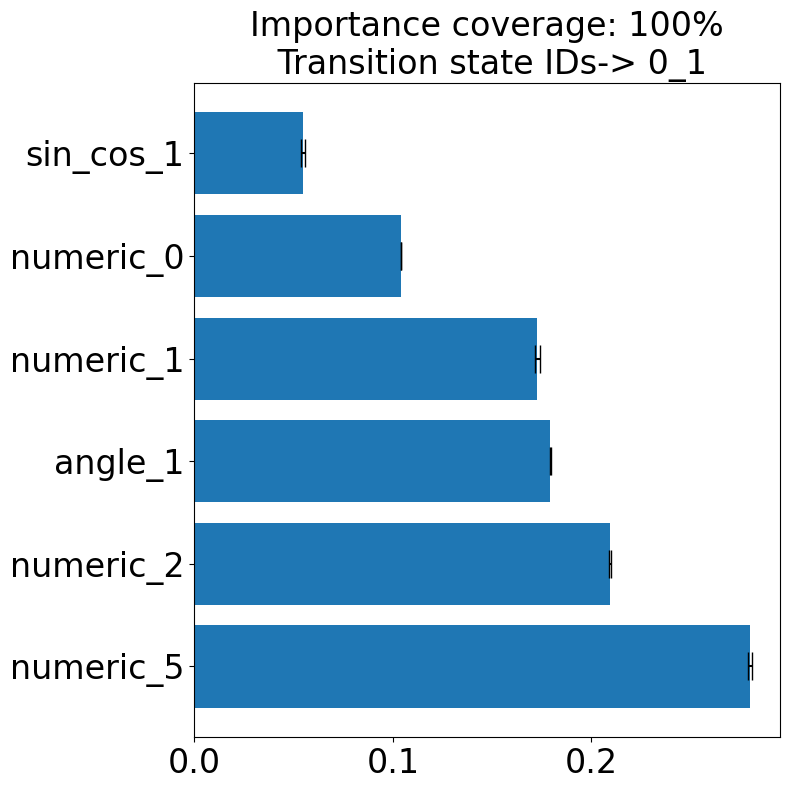

In [20]:
# MDTerp step 3: Summarize feature importance for each of the transition states.
import matplotlib.pyplot as plt
from MDTerp.utils import transition_summary

feature_names_loc = result_dir + 'MDTerp_feature_names.npy'
feature_names = np.load(feature_names_loc)
all_result_loc = result_dir + 'MDTerp_results_all.pkl'

# summary is a dictionary with individual keys for each class transition in the dataset. Each key has the mean and standard deviation of feature importance for all explanations generated for that transition
summary = transition_summary(all_result_loc, importance_coverage = 1.00)

# Loop over all the transitions
for ii in summary:
    ordered_nonzero_indices = np.argsort(summary[ii][0])[::-1][:np.nonzero(summary[ii][0])[0].shape[0]]
    
    ordered_mean = summary[ii][0][ordered_nonzero_indices]
    ordered_std = summary[ii][1][ordered_nonzero_indices]
    
    fig, ax = plt.subplots(figsize = (8,8))
    ax.barh(np.arange(ordered_mean.shape[0]), ordered_mean, xerr = ordered_std, capsize = 10)
    ax.set_title('Importance coverage: ' + str(int(100*np.sum(ordered_mean))) + '%' + '\n Transition state IDs-> ' + ii, fontsize = 24)
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.set_yticks(np.arange(ordered_nonzero_indices.shape[0]))
    ax.set_yticklabels(np.array(feature_names)[ordered_nonzero_indices])
    fig.tight_layout()

In [21]:
# For all the investigated points, fetch n_th dominant features (n = 0 is most dominant).
from MDTerp.utils import dominant_feature
dominant_feature(all_result_loc, n = 0)

{np.int64(1329): np.int64(5),
 np.int64(17176): np.int64(5),
 np.int64(10556): np.int64(5),
 np.int64(11937): np.int64(5),
 np.int64(1652): np.int64(5),
 np.int64(5767): np.int64(5),
 np.int64(18197): np.int64(5),
 np.int64(9293): np.int64(5),
 np.int64(12903): np.int64(5),
 np.int64(14798): np.int64(5)}

In [22]:
# Note: High standard deviation of feature importance likely indicates:
# (i) inaccuracy due to small neighborhood size (solution: increase neighborhood size -> num_samples hyperparameter) or,
# (ii) highly non-linear behavior in the sampled points (solution: choose prob_threshold closer to but less than 0.50) or,
# (iii) black-box model has multiple transition pathways classified under a single transition state or is simply bad (solution: train a better black-box model for the main task).